# XGB Test

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Load Data and Process
train = pd.read_csv("data/train.csv")
target = train['target']
ft_train = train.drop(['target', 'ID_code'], axis=1)

# Data Splitting

In [4]:
# preproc things
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [8]:
X_scale = StandardScaler().fit_transform(ft_train)
X_train, X_test, y_train, y_test = \
        train_test_split(X_scale, target, test_size=.4, 
                         random_state=42)

# Fit XGB

In [11]:
from xgboost import XGBClassifier

In [14]:
# adding gpu bits
param = {}
param['gpu_id'] = 1
param['tree_method'] = 'gpu_hist'

In [16]:
model = XGBClassifier(**param)

In [18]:
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='auc',
          verbose=True)

[0]	validation_0-auc:0.65047	validation_1-auc:0.64026
[1]	validation_0-auc:0.69156	validation_1-auc:0.67519
[2]	validation_0-auc:0.72088	validation_1-auc:0.69392
[3]	validation_0-auc:0.74225	validation_1-auc:0.71058
[4]	validation_0-auc:0.76206	validation_1-auc:0.72601
[5]	validation_0-auc:0.77776	validation_1-auc:0.73460
[6]	validation_0-auc:0.78652	validation_1-auc:0.73745
[7]	validation_0-auc:0.79780	validation_1-auc:0.74642
[8]	validation_0-auc:0.81185	validation_1-auc:0.75368
[9]	validation_0-auc:0.81863	validation_1-auc:0.75753
[10]	validation_0-auc:0.82945	validation_1-auc:0.76410
[11]	validation_0-auc:0.83777	validation_1-auc:0.76975
[12]	validation_0-auc:0.84684	validation_1-auc:0.77367
[13]	validation_0-auc:0.85384	validation_1-auc:0.77851
[14]	validation_0-auc:0.86191	validation_1-auc:0.78345
[15]	validation_0-auc:0.86829	validation_1-auc:0.78633
[16]	validation_0-auc:0.87287	validation_1-auc:0.78969
[17]	validation_0-auc:0.87655	validation_1-auc:0.79130
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [20]:
y_pred = model.predict(X_test)

# Confusion Matrix

In [23]:
from sklearn.metrics import plot_confusion_matrix

In [21]:
class_names = ['no_transact', 'transact']

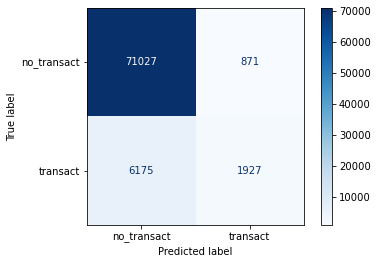

In [26]:
plot_confusion_matrix(model, X_test, y_test,
                     display_labels=class_names,
                     cmap=plt.cm.Blues)

# Hyperparam Tuning XGB

In [29]:
from tune_sklearn import TuneGridSearchCV

In [27]:
xgb_params = {
    "eta": (0.01, 0.2),
    "gamma": (0, 20),
    "max_depth": (3, 10),
    "min_child_weight": (1, 10)
}

In [ ]:
params['verbose']

In [30]:
xgb_model = XGBClassifier(**param)
xgb_search = TuneGridSearchCV(
    xgb_model,
    xgb_params,
    n_jobs=4
)

In [ ]:
xgb_search.fit(X_train, y_train)

In [39]:
print(xgb_search.best_params_) #.cv_results_

{'eta': 0.01, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1}
